ADF Statistic: -5.67623575733521
p-value: 8.69193793530242e-07
The series is stationary.
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3244.145, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3167.548, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3242.146, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3120.880, Time=0.06 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3103.464, Time=0.11 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=3086.260, Time=0.14 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=3084.852, Time=0.20 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=3082.854, Time=0.09 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=3084.265, Time=0.03 sec
 ARIMA(5,1,1)(0,0,0)[0]       

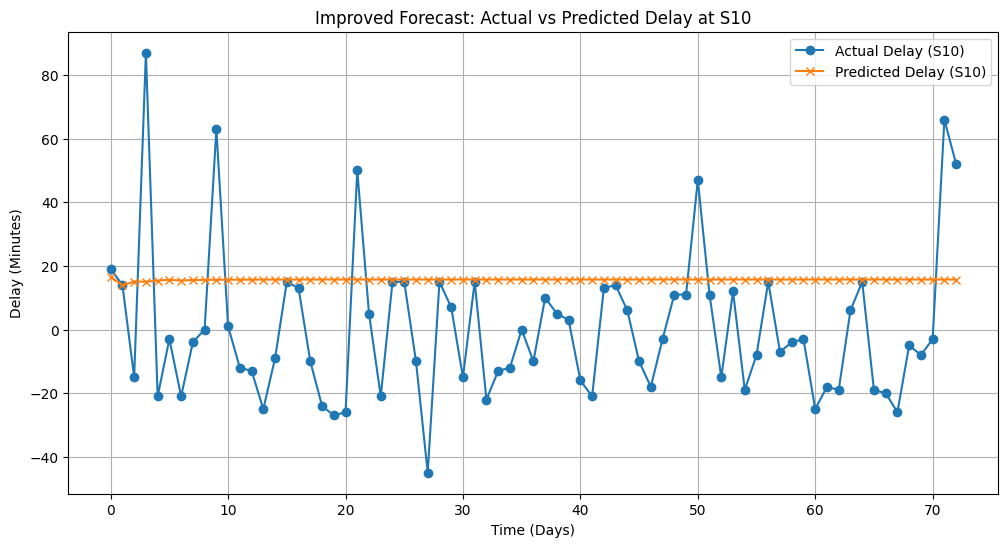

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('updatedData.csv')

# Convert relevant columns to numeric (if not already)
for col in df.columns[1:]:  # Skip the 'date' column
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with NaN values (if any)
df.dropna(inplace=True)

# Create feature vectors for stations S1 to S9
stations_data = []
for i in range(1, 10):  # S1 to S9
    station_vector = df[[f'S{i}', f'Temperature_{i}', f'Wind_Speed_{i}',
                         f'weather_code_{i}', f'Distance_travelled_{i}']].values
    stations_data.append(station_vector)

# Stack station data to create a time-series matrix (rows = dates, columns = features)
stations_data_matrix = np.hstack(stations_data)

# Prepare the target variable (delay at S10)
target = df['S10'].values

# Scale the features for better model performance
scaler = StandardScaler()
stations_data_scaled = scaler.fit_transform(stations_data_matrix)

# Split into train and test sets (e.g., last 30 days for testing)
train_size = int(0.8 * len(stations_data_scaled))
train_data, test_data = stations_data_scaled[:train_size], stations_data_scaled[train_size:]
train_target, test_target = target[:train_size], target[train_size:]

# ADF Test to check stationarity
result = adfuller(train_target)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary. Consider additional differencing or transformations.")

# Use auto_arima to find the best (p, d, q) parameters
auto_model = auto_arima(train_target, seasonal=False, trace=True,
                        error_action='ignore', suppress_warnings=True)
print(auto_model.summary())

# Fit the best ARIMA model
model = auto_model.fit(train_target)

# Forecast the next values (predict delay at S10 for the test set)
forecast = model.predict(n_periods=len(test_target))

# Evaluate the model performance
mae = mean_absolute_error(test_target, forecast)
mse = mean_squared_error(test_target, forecast)
rmse = np.sqrt(mse)
r2 = r2_score(test_target, forecast)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

# Plot Actual vs Predicted Delay
plt.figure(figsize=(12, 6))
plt.plot(test_target, label='Actual Delay (S10)', marker='o')
plt.plot(forecast, label='Predicted Delay (S10)', marker='x')
plt.title('Improved Forecast: Actual vs Predicted Delay at S10')
plt.xlabel('Time (Days)')
plt.ylabel('Delay (Minutes)')
plt.legend()
plt.grid(True)
plt.show()


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

Best SARIMA order: (1, 0, 1)
Best seasonal order: (0, 0, 1, 7)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (MAE): 23.64498212599988
Mean Squared Error (MSE): 877.5052573818094
Root Mean Squared Error (RMSE): 29.622715226356437
R² Score: -0.6266807005478343


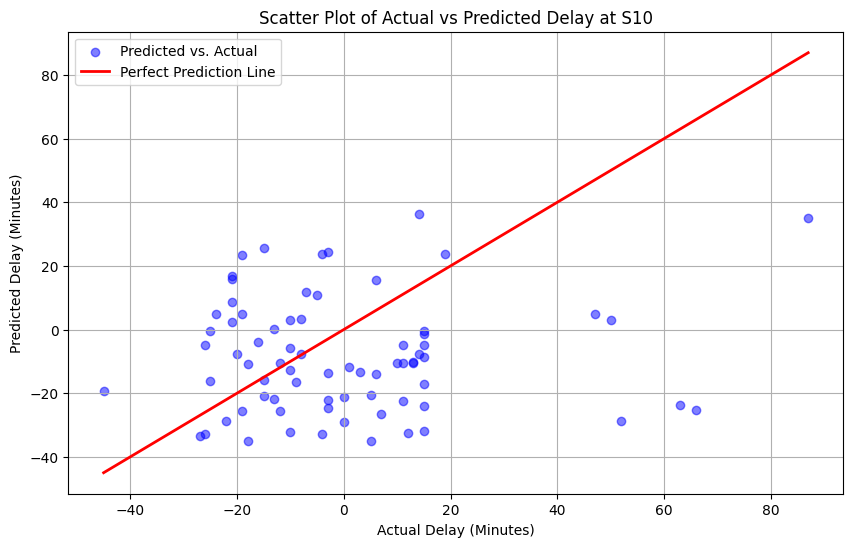

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from itertools import product

# Load the dataset
df = pd.read_csv('updatedData.csv')

# Convert relevant columns to numeric (if not already)
for col in df.columns[1:]:  # Skip the 'date' column
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with NaN values (if any)
df.dropna(inplace=True)

# Prepare the exogenous features for stations S1 to S9
exogenous_features = []
for i in range(1, 10):
    station_features = df[[f'Temperature_{i}', f'Wind_Speed_{i}', f'weather_code_{i}', f'Distance_travelled_{i}']]
    exogenous_features.append(station_features.values)
exog_data = np.hstack(exogenous_features)

# Target variable: delay at S10
target = df['S10'].values

# Scale the features for better model performance
scaler = StandardScaler()
exog_data_scaled = scaler.fit_transform(exog_data)

# Split into train and test sets (e.g., last 30 days for testing)
train_size = int(0.8 * len(exog_data_scaled))
train_data, test_data = exog_data_scaled[:train_size], exog_data_scaled[train_size:]
train_target, test_target = target[:train_size], target[train_size:]

# Define a range of hyperparameters for tuning
p = d = q = range(0, 2)  # SARIMA params
P = D = Q = range(0, 2)  # Seasonal SARIMA params
m = [1, 7]  # Seasonality (daily or weekly)

# Hyperparameter tuning using grid search
best_score, best_order, best_seasonal_order = float("inf"), None, None
for order in product(p, d, q):
    for seasonal_order in product(P, D, Q, m):
        try:
            model = SARIMAX(train_target, exog=train_data, order=order,
                            seasonal_order=seasonal_order, enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            score = mean_squared_error(train_target, results.fittedvalues)
            if score < best_score:
                best_score, best_order, best_seasonal_order = score, order, seasonal_order
        except Exception as e:
            continue

print(f"Best SARIMA order: {best_order}")
print(f"Best seasonal order: {best_seasonal_order}")

# Fit the best SARIMAX model
best_model = SARIMAX(train_target, exog=train_data, order=best_order,
                     seasonal_order=best_seasonal_order, enforce_stationarity=False,
                     enforce_invertibility=False)
best_results = best_model.fit(disp=False)

# Forecast the next values (predict delay at S10 for the test set)
forecast = best_results.get_forecast(steps=len(test_target), exog=test_data).predicted_mean

# Evaluate the model performance
mae = mean_absolute_error(test_target, forecast)
mse = mean_squared_error(test_target, forecast)
rmse = np.sqrt(mse)
r2 = r2_score(test_target, forecast)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

# Scatter Plot of Actual vs Predicted Delay
plt.figure(figsize=(10, 6))
plt.scatter(test_target, forecast, alpha=0.5, color='blue', label='Predicted vs. Actual')
plt.plot([min(test_target), max(test_target)], [min(test_target), max(test_target)], color='red', lw=2, label='Perfect Prediction Line')
plt.title('Scatter Plot of Actual vs Predicted Delay at S10')
plt.xlabel('Actual Delay (Minutes)')
plt.ylabel('Predicted Delay (Minutes)')
plt.legend()
plt.grid(True)
plt.show()


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

Best SARIMA order: (1, 0, 0)
Best seasonal order: (1, 0, 1, 7)


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Absolute Error (MAE): 25.25099278979077
Mean Squared Error (MSE): 1137.0823005712425
Root Mean Squared Error (RMSE): 33.720650951178904
R² Score: -1.107873220945235


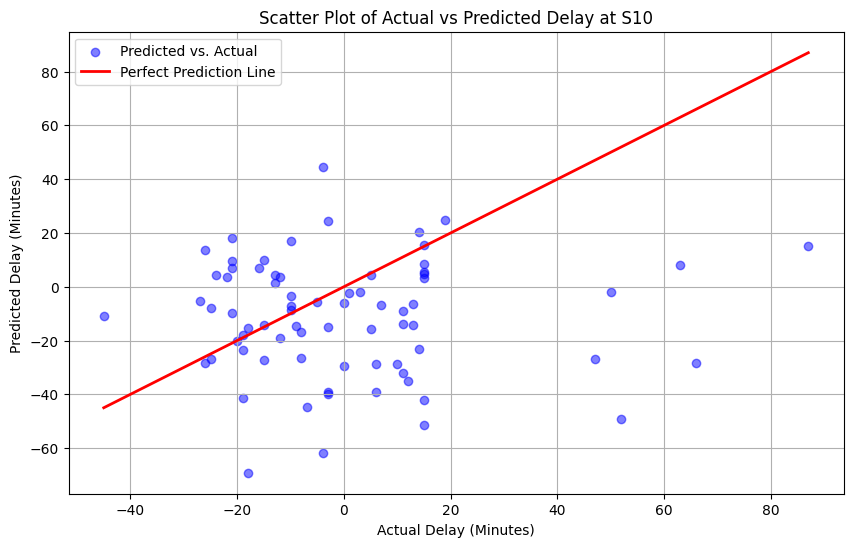

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from itertools import product

# Load the dataset
df = pd.read_csv('updatedData.csv')

# Convert relevant columns to numeric (if not already)
for col in df.columns[1:]:  # Skip the 'date' column
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with NaN values (if any)
df.dropna(inplace=True)

# Add lag feature for S9 delay to help predict S10
df['S9_lag'] = df['S9'].shift(1)
df.dropna(inplace=True)  # Drop any resulting NaN after shifting

# Add interaction features for weather conditions at each station
for i in range(1, 10):
    df[f'Weather_Temp_Interaction_{i}'] = df[f'weather_code_{i}'] * df[f'Temperature_{i}']
    df[f'Weather_Wind_Interaction_{i}'] = df[f'weather_code_{i}'] * df[f'Wind_Speed_{i}']

# Outlier detection and treatment for delay columns (using Z-score method)
def treat_outliers(data, threshold=3):
    z_scores = (data - np.mean(data)) / np.std(data)
    return np.where(abs(z_scores) > threshold, np.median(data), data)

# Apply outlier treatment on delay columns
for i in range(1, 11):  # S1 to S10
    df[f'S{i}'] = treat_outliers(df[f'S{i}'])

# Prepare the exogenous features (including lag and interaction terms)
exogenous_features = []
for i in range(1, 10):
    station_features = df[[f'Temperature_{i}', f'Wind_Speed_{i}', f'weather_code_{i}', f'Distance_travelled_{i}',
                           f'Weather_Temp_Interaction_{i}', f'Weather_Wind_Interaction_{i}']]
    exogenous_features.append(station_features.values)

# Include the lag feature for S9
exogenous_features.append(df[['S9_lag']].values)

# Stack all exogenous features
exog_data = np.hstack(exogenous_features)

# Target variable: delay at S10
target = df['S10'].values

# Scale the features for better model performance
scaler = StandardScaler()
exog_data_scaled = scaler.fit_transform(exog_data)

# Split into train and test sets (e.g., last 30 days for testing)
train_size = int(0.8 * len(exog_data_scaled))
train_data, test_data = exog_data_scaled[:train_size], exog_data_scaled[train_size:]
train_target, test_target = target[:train_size], target[train_size:]

# Define a range of hyperparameters for tuning
p = d = q = range(0, 2)  # SARIMA params
P = D = Q = range(0, 2)  # Seasonal SARIMA params
m = [1, 7]  # Seasonality (daily or weekly)

# Hyperparameter tuning using grid search
best_score, best_order, best_seasonal_order = float("inf"), None, None
for order in product(p, d, q):
    for seasonal_order in product(P, D, Q, m):
        try:
            model = SARIMAX(train_target, exog=train_data, order=order,
                            seasonal_order=seasonal_order, enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            score = mean_squared_error(train_target, results.fittedvalues)
            if score < best_score:
                best_score, best_order, best_seasonal_order = score, order, seasonal_order
        except Exception as e:
            continue

print(f"Best SARIMA order: {best_order}")
print(f"Best seasonal order: {best_seasonal_order}")

# Fit the best SARIMAX model
best_model = SARIMAX(train_target, exog=train_data, order=best_order,
                     seasonal_order=best_seasonal_order, enforce_stationarity=False,
                     enforce_invertibility=False)
best_results = best_model.fit(disp=False)

# Forecast the next values (predict delay at S10 for the test set)
forecast = best_results.get_forecast(steps=len(test_target), exog=test_data).predicted_mean

# Evaluate the model performance
mae = mean_absolute_error(test_target, forecast)
mse = mean_squared_error(test_target, forecast)
rmse = np.sqrt(mse)
r2 = r2_score(test_target, forecast)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

# Scatter Plot of Actual vs Predicted Delay
plt.figure(figsize=(10, 6))
plt.scatter(test_target, forecast, alpha=0.5, color='blue', label='Predicted vs. Actual')
plt.plot([min(test_target), max(test_target)], [min(test_target), max(test_target)], color='red', lw=2, label='Perfect Prediction Line')
plt.title('Scatter Plot of Actual vs Predicted Delay at S10')
plt.xlabel('Actual Delay (Minutes)')
plt.ylabel('Predicted Delay (Minutes)')
plt.legend()
plt.grid(True)
plt.show()


Training Linear Regression...
Training Random Forest...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2651
[LightGBM] [Info] Number of data points in the train set: 290, number of used features: 54
[LightGBM] [Info] Start training from score 9.610345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

<Figure size 1200x800 with 0 Axes>

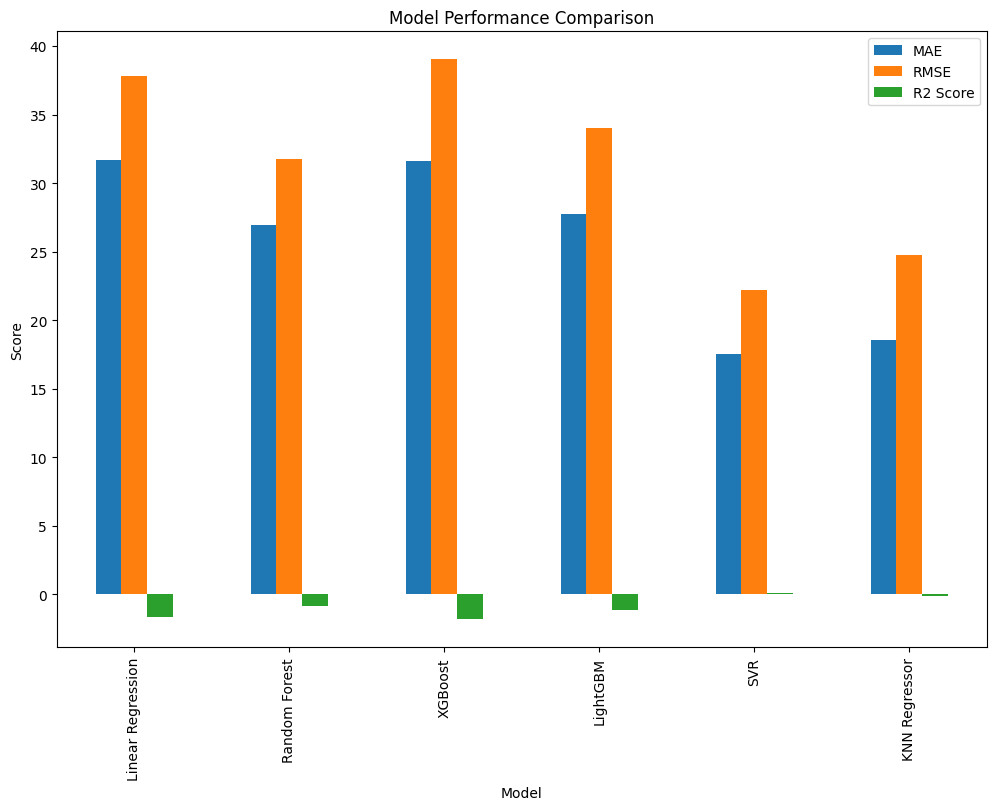

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('updatedData.csv')

# Convert relevant columns to numeric (if not already)
for col in df.columns[1:]:  # Skip the 'date' column
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with NaN values (if any)
df.dropna(inplace=True)

# Feature Engineering: Add lagged features for previous stations and rolling statistics
for i in range(1, 10):  # S1 to S9
    # Lag features
    df[f'S{i}_lag'] = df[f'S{i}'].shift(1)
    
    # Rolling mean and standard deviation
    df[f'S{i}_rolling_mean'] = df[f'S{i}'].rolling(window=3).mean()
    df[f'S{i}_rolling_std'] = df[f'S{i}'].rolling(window=3).std()

# Drop any resulting NaN values after shifting/rolling operations
df.dropna(inplace=True)

# Prepare the exogenous features (including lag and rolling features)
exogenous_features = []
for i in range(1, 10):
    station_features = df[[f'Temperature_{i}', f'Wind_Speed_{i}', f'weather_code_{i}', f'Distance_travelled_{i}',
                           f'S{i}_lag', f'S{i}_rolling_mean', f'S{i}_rolling_std']]
    exogenous_features.append(station_features.values)

# Stack all exogenous features
exog_data = np.hstack(exogenous_features)

# Target variable: delay at S10
target = df['S10'].values

# Split into train and test sets (last 20% for testing)
train_size = int(0.8 * len(exog_data))
train_data, test_data = exog_data[:train_size], exog_data[train_size:]
train_target, test_target = target[:train_size], target[train_size:]

# Define the models to be tested
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, subsample=0.7, colsample_bytree=0.7, random_state=42, objective='reg:squarederror'),
    "LightGBM": LGBMRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, subsample=0.7, colsample_bytree=0.7, random_state=42),
    "SVR": SVR(kernel='rbf', C=100, epsilon=0.1),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5)
}

# Dictionary to store model performance
results = {
    "Model": [],
    "MAE": [],
    "MSE": [],
    "RMSE": [],
    "R2 Score": []
}

# Loop through each model, fit, predict, and evaluate
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(train_data, train_target)
    predictions = model.predict(test_data)
    
    # Calculate metrics
    mae = mean_absolute_error(test_target, predictions)
    mse = mean_squared_error(test_target, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_target, predictions)
    
    # Append results
    results["Model"].append(model_name)
    results["MAE"].append(mae)
    results["MSE"].append(mse)
    results["RMSE"].append(rmse)
    results["R2 Score"].append(r2)

# Display results in a DataFrame for easy comparison
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df)

# Plot Model Comparison
plt.figure(figsize=(12, 8))
results_df.set_index("Model")[["MAE", "RMSE", "R2 Score"]].plot(kind='bar', figsize=(12, 8))
plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.legend()
plt.show()


Training Linear Regression...
Training Random Forest...
Training XGBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2764
[LightGBM] [Info] Number of data points in the train set: 290, number of used features: 96
[LightGBM] [Info] Start training from score 9.610345
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

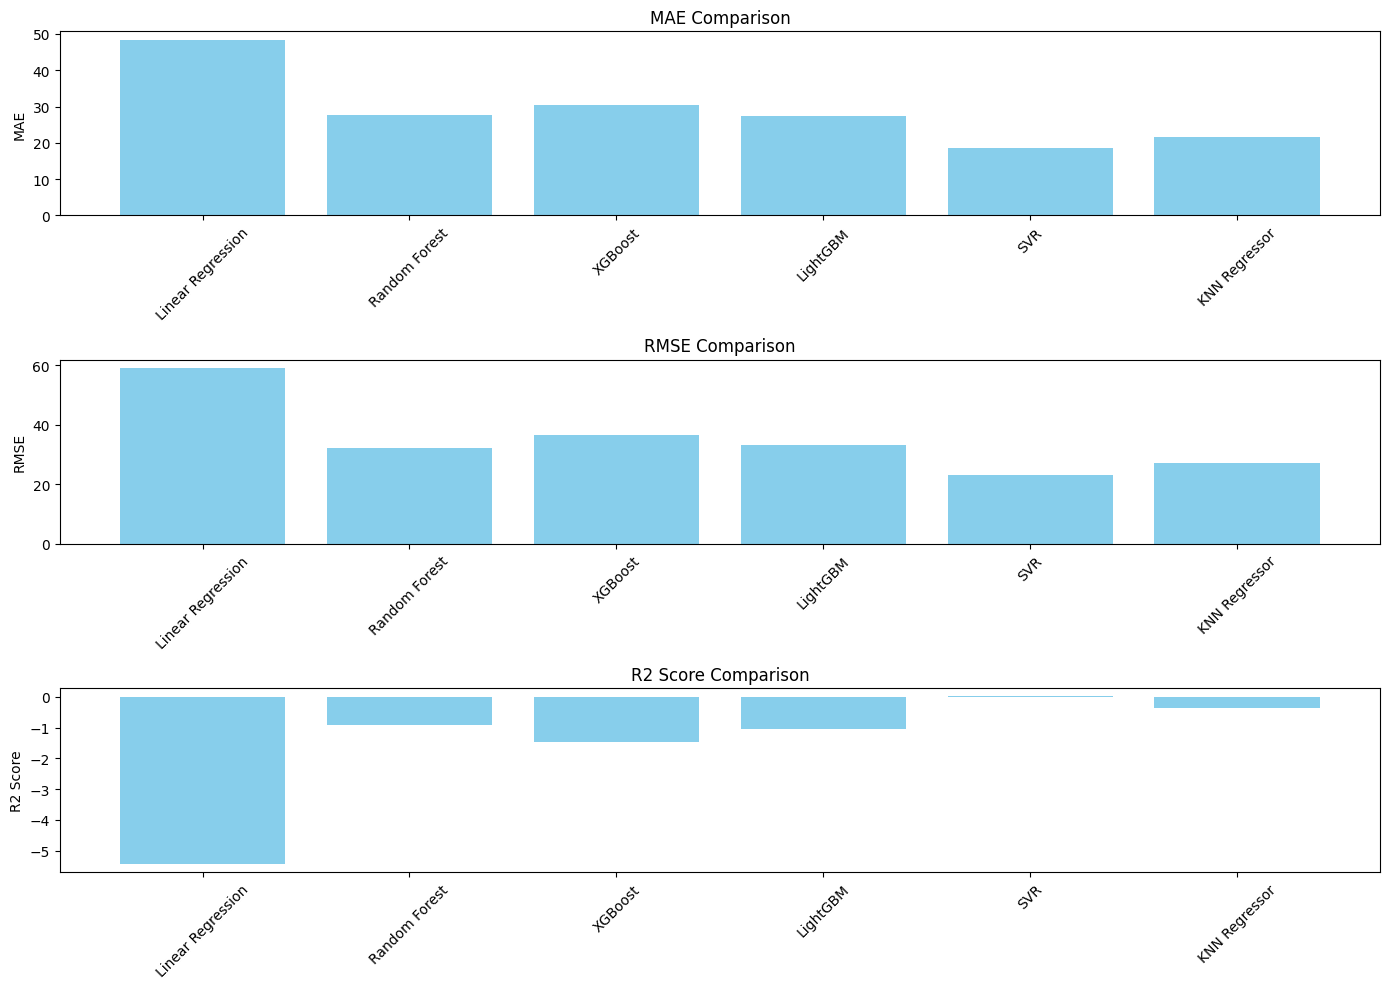

In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('updatedData.csv')

# Convert relevant columns to numeric (if not already)
for col in df.columns[1:]:  # Skip the 'date' column
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with NaN values (if any)
df.dropna(inplace=True)

# Initialize OneHotEncoder for weather codes
weather_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Feature Engineering: Add lagged features for previous stations and rolling statistics
exogenous_features = []
for i in range(1, 10):  # S1 to S9
    # Encode weather codes
    weather_encoded = weather_encoder.fit_transform(df[[f'weather_code_{i}']])
    
    # Stack encoded weather with other features
    station_features = np.hstack([
        df[[f'Temperature_{i}', f'Wind_Speed_{i}', f'Distance_travelled_{i}']].values,
        weather_encoded,  # One-hot encoded weather codes
        df[[f'S{i}']].shift(1).values,  # Lagged feature
        df[[f'S{i}']].rolling(window=3).mean().values,  # Rolling mean
        df[[f'S{i}']].rolling(window=3).std().values  # Rolling std deviation
    ])
    
    exogenous_features.append(station_features)

# Stack all exogenous features and drop NaN rows created by rolling and lagged features
exog_data = np.hstack(exogenous_features)
exog_data = exog_data[~np.isnan(exog_data).any(axis=1)]

# Target variable: delay at S10
target = df['S10'].values[len(df) - len(exog_data):]  # Adjust target length

# Scale the features for better model performance
scaler = StandardScaler()
exog_data_scaled = scaler.fit_transform(exog_data)

# Split into train and test sets (last 20% for testing)
train_size = int(0.8 * len(exog_data_scaled))
train_data, test_data = exog_data_scaled[:train_size], exog_data_scaled[train_size:]
train_target, test_target = target[:train_size], target[train_size:]

# Define the models to be tested
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, subsample=0.7, colsample_bytree=0.7, random_state=42, objective='reg:squarederror'),
    "LightGBM": LGBMRegressor(n_estimators=1000, learning_rate=0.01, max_depth=5, subsample=0.7, colsample_bytree=0.7, random_state=42),
    "SVR": SVR(kernel='rbf', C=100, epsilon=0.1),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5)
}

# Dictionary to store model performance
results = {
    "Model": [],
    "MAE": [],
    "MSE": [],
    "RMSE": [],
    "R2 Score": []
}

# Loop through each model, fit, predict, and evaluate
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(train_data, train_target)
    predictions = model.predict(test_data)
    
    # Calculate metrics
    mae = mean_absolute_error(test_target, predictions)
    mse = mean_squared_error(test_target, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_target, predictions)
    
    # Append results
    results["Model"].append(model_name)
    results["MAE"].append(mae)
    results["MSE"].append(mse)
    results["RMSE"].append(rmse)
    results["R2 Score"].append(r2)

# Display results in a DataFrame for easy comparison
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df)

# Plot Model Comparison
plt.figure(figsize=(14, 10))

# Separate subplots for each metric for clarity
metrics = ["MAE", "RMSE", "R2 Score"]
for idx, metric in enumerate(metrics, 1):
    plt.subplot(3, 1, idx)
    plt.bar(results_df["Model"], results_df[metric], color='skyblue')
    plt.title(f"{metric} Comparison")
    plt.ylabel(metric)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
